In [2]:
import sys
sys.path.append('..')
%load_ext autoreload

# Figuring out the cropping factor for MedMNIST chest x-rays

In [8]:
%autoreload 2
from model_zoo.datasets.image import MedMNIST
from dotenv import load_dotenv
import os

load_dotenv(override=True)
data_dir = os.environ.get("DATA_DIR", './data')

healthy = MedMNIST(
    root=data_dir,
    subclass='ChestMNIST',
    role='train',
    valid_fraction=0.1,
    seed=0,
    device='cuda:0',
)
pnumonia = MedMNIST(
    root=data_dir,
    subclass='PneumoniaMNIST',
    role='train',
    valid_fraction=0.1,
    seed=0,
    device='cuda:0',
)

Using downloaded and verified file: ./data/chestmnist.npz
Using downloaded and verified file: ./data/pneumoniamnist.npz


In [25]:
from lpips import LPIPS

lpips_kwargs = (
    {
        "pretrained": True,
        "net": "alex",
        "version": "0.1",
        "lpips": True,
        "spatial": False,
        "pnet_rand": False,
        "pnet_tune": False,
        "use_dropout": True,
        "model_path": None,
        "eval_mode": True,
        "verbose": False,
    }
)

perceptual_function = LPIPS(**lpips_kwargs)


/home/hamid/miniconda3/envs/ood-detection/lib/python3.10/site-packages/torchvision/models/_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
/home/hamid/miniconda3/envs/ood-detection/lib/python3.10/site-packages/torchvision/models/_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=AlexNet_Weights.IMAGENET1K_V1`. You can also use `weights=AlexNet_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


In [51]:
# sample 1000 indices from 0 to len(healthy) with replacement
import numpy as np
from tqdm import tqdm
import torch
from torchvision.transforms import CenterCrop, Resize

np.random.seed(0)
healthy_idx = np.random.choice(len(healthy), 128, replace=True)
pnumonia_idx = np.random.choice(len(pnumonia), 128, replace=True)

best_sz = None
mn_dist = float('inf')

for h in range(1, 29): 
    for w in range(1, 29):
        sz = (h, w)
        transform_crop = CenterCrop(sz)
        transform_resize = Resize((32, 32))
        # do a center crop of size sz
        healthy_img = transform_resize(transform_crop(healthy.x[healthy_idx]))
        pnumonia_img = transform_resize(pnumonia.x[pnumonia_idx])
        with torch.no_grad():
            dist = perceptual_function(healthy_img, pnumonia_img).squeeze().mean()
        
        if dist < mn_dist:
            mn_dist = dist
            best_sz = sz

print("Best center resize is:", best_sz, "produces LPIPS distance of",  mn_dist.item())


/home/hamid/miniconda3/envs/ood-detection/lib/python3.10/site-packages/torchvision/transforms/functional.py:1603: UserWarning: The default value of the antialias parameter of all the resizing transforms (Resize(), RandomResizedCrop(), etc.) will change from None to True in v0.17, in order to be consistent across the PIL and Tensor backends. To suppress this warning, directly pass antialias=True (recommended, future default), antialias=None (current default, which means False for Tensors and True for PIL), or antialias=False (only works on Tensors - PIL will still use antialiasing). This also applies if you are using the inference transforms from the models weights: update the call to weights.transforms(antialias=True).
  warnings.warn(


Best center resize is: (27, 18) produces LPIPS distance of 0.06563727557659149


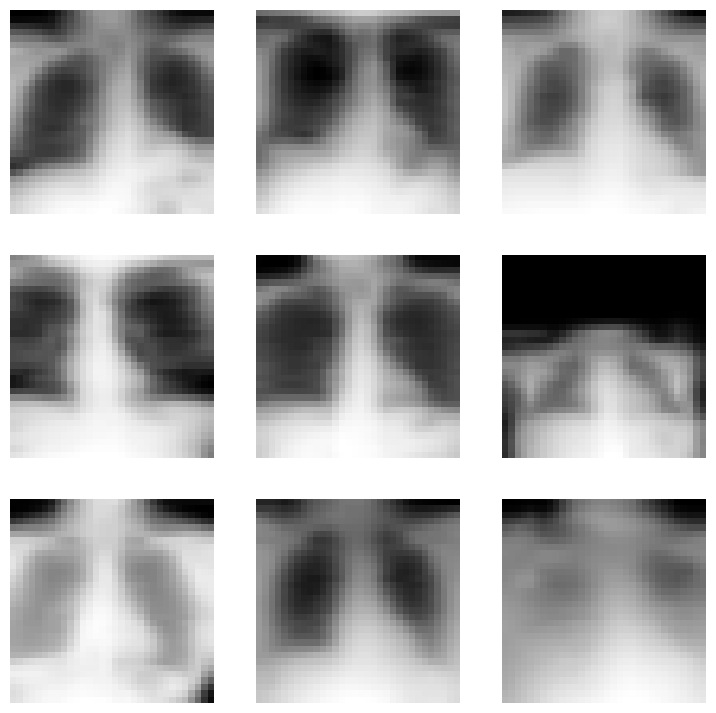

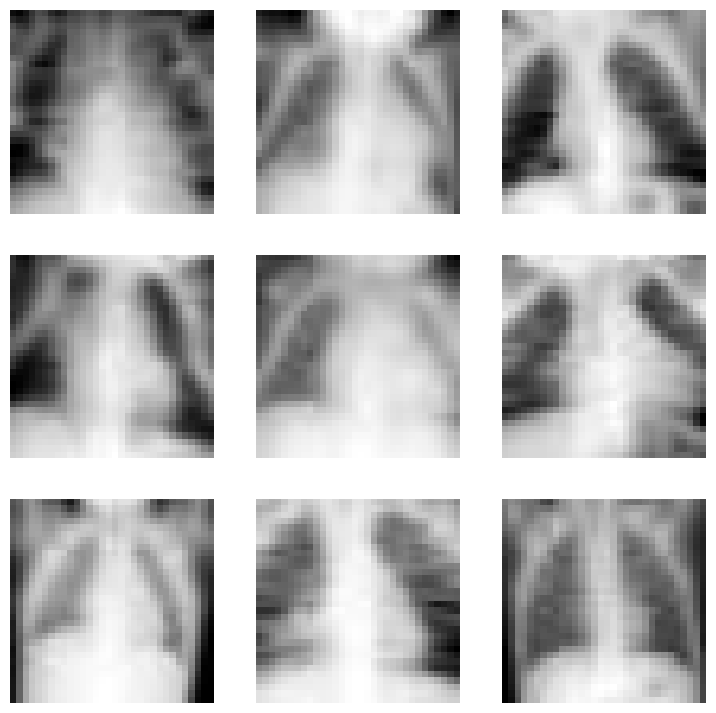

In [46]:

transform_crop = CenterCrop(best_sz)
transform_resize = Resize((32, 32))

healthy_img = transform_resize(transform_crop(healthy.x[healthy_idx]))
pnumonia_img = transform_resize(pnumonia.x[pnumonia_idx])

import matplotlib.pyplot as plt
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(healthy_img[i*3+j].squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()
fig, axs = plt.subplots(3, 3, figsize=(9, 9))
for i in range(3):
    for j in range(3):
        axs[i, j].imshow(pnumonia_img[i*3+j].squeeze(), cmap='gray')
        axs[i, j].axis('off')
plt.show()
